<h1 align=center><font size = 5>Segmenting and Clustering The Most Visited Cities In the World</font></h1>


In [1]:
#importing important libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
print('done')

done


## DATA WRANGLING

Firstly we will scrape wikipedia to get the 100 most visitied cities in the World. Then, using the geopy library we will get their location(longitude and latitude). That is necessary because we will need them to draw a cirlceMarker on each city and get the 200 most popular venues of each city.

### BUILDING THE DATAFRAME CONTAINING THE 100 CITIES

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors'
website = requests.get(url).text
soup = BeautifulSoup(website , 'lxml')

#getting the table then the rows
my_table = soup.find('table', {'class' : 'wikitable sortable'})
for tag in my_table.find_all('tbody'):
    all_rows = tag.find_all('tr')
    
# initiating data container
city_names = []
country_names = []
visitors_count = []
count = 0
#extracting the data from the rows
for row in all_rows[1:]:
    count = count+1
    row_data = row.find_all('td')
    city_names.append(row_data[2].text.strip())
    country_names.append(row_data[3].text.strip())
    visitors_count.append(row_data[4].text.strip())
    if(count>=100): break;
#inserting data into dataframe
column_names = ['City', 'Country', 'Arrivals 2018']
df = pd.DataFrame(columns = column_names)
df['City'] = city_names
df['Country'] = country_names
df['Arrivals 2018'] = visitors_count
df.head()

,City,Country,Arrivals 2018
0,Hong Kong,Hong Kong,"29,262,700"
1,Bangkok,Thailand,"24,177,500"
2,London,United Kingdom,"19,233,000"
3,Macau,Macau,"18,931,400"
4,Singapore,Singapore,"18,551,200"


In [4]:
#getting location data for each city
def loc_fetcher(addresses):
    from geopy.geocoders import Nominatim
    latitude = []
    longitude = []
    if(len(addresses) != 0):
        for address in addresses:
            geolocator = Nominatim(user_agent="ny_explorer")
            location = geolocator.geocode(address)
            latitude.append(location.latitude)
            longitude.append(location.longitude)
    print('done')
    return (latitude, longitude)

In [5]:
latitude, longitude = loc_fetcher(df['City'].values)

done


In [6]:
#joining each city with its location data
df.insert(1, 'CityLatitude', latitude)
df.insert(2, 'CityLongitude', longitude)
df.to_csv('df_with_coordinates')

In [7]:
df.head()

,City,CityLatitude,CityLongitude,Country,Arrivals 2018
0,Hong Kong,22.279328,114.162813,Hong Kong,"29,262,700"
1,Bangkok,13.754253,100.493087,Thailand,"24,177,500"
2,London,51.507322,-0.127647,United Kingdom,"19,233,000"
3,Macau,22.175760,113.551414,Macau,"18,931,400"
4,Singapore,1.357107,103.819499,Singapore,"18,551,200"


### Visualizing the cities on a map

Before we continue wrangling data, let's see how the most famous cities a re spread around the world

In [8]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
world_map = folium.Map([0, 0], zoom_start = 2)

# add markers to the map
for lat, lon, city in zip(df['CityLatitude'], df['CityLongitude'], df['City']):
    label = folium.Popup(str(city), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(world_map)
       
world_map

### Getting the top venues for each city using Foursquare

In [9]:
#Foursquare Credentials
CLIENT_ID = 'EJ3SYZZBS4S3IYQ0JEXP5WCJN1JZOFQYIPTZREL0BQTENUV2' # your Foursquare ID
CLIENT_SECRET = 'Q3EXQ3CZ5T5QEKXVJPYWXUX0HMIFZ4IYZEM3U2FKYPHHXEBJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EJ3SYZZBS4S3IYQ0JEXP5WCJN1JZOFQYIPTZREL0BQTENUV2
CLIENT_SECRET:Q3EXQ3CZ5T5QEKXVJPYWXUX0HMIFZ4IYZEM3U2FKYPHHXEBJ


In [11]:
def getWorldVenues(names, latitudes, longitudes, radius=10000, LIMIT = 200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
             100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [12]:
#getting the 100 venues for each City
world_top_venues = getWorldVenues(names=df['City'],
                                   latitudes=df['CityLatitude'],
                                   longitudes=df['CityLongitude']
                                  )

Hong Kong
Bangkok
London
Macau
Singapore
Paris
Dubai
New York City
Kuala Lumpur
Istanbul
Delhi
Antalya
Shenzhen
Mumbai
Phuket
Rome
Tokyo
Pattaya
Taipei
Mecca
Guangzhou
Prague
Medina
Seoul
Amsterdam
Agra
Miami
Osaka
Las Vegas
Shanghai
Ho Chi Minh City
Denpasar
Barcelona
Los Angeles
Milan
Chennai
Vienna
Johor Bahru
Jaipur
Cancún
Berlin
Cairo
Athens
Orlando
Moscow
Venice
Madrid
Ha Long
Riyadh
Dublin
Florence
Hanoi
Toronto
Johannesburg
Sydney
Munich
Jakarta
Beijing
Saint Petersburg
Brussels
Jerusalem
Budapest
Lisbon
Dammam
Penang Island
Heraklion
Kyoto
Zhuhai
Vancouver
Chiang Mai
Copenhagen
San Francisco
Melbourne
Warsaw
Marrakesh
Kolkata
Cebu City
Auckland
Tel Aviv
Guilin
Honolulu
Hurghada
Kraków
Muğla
Buenos Aires
Chiba
Frankfurt am Main
Stockholm
Lima
Da Nang
Batam
Nice
Fukuoka
Abu Dhabi
Jeju
Porto
Rhodes
Rio de Janeiro
Krabi
Bangalore


In [2]:
world_top_venues = pd.read_csv('world_top_venues')
world_top_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hong Kong,22.279328,114.162813,Hong Kong Park Aviary (香港公園觀鳥園),22.277140,114.161399,Zoo
1,Hong Kong,22.279328,114.162813,Hong Kong Park (香港公園),22.277700,114.161854,Park
2,Hong Kong,22.279328,114.162813,The Upper House (奕居),22.277499,114.166323,Hotel
3,Hong Kong,22.279328,114.162813,The Asia Society Hong Kong Center (亞洲協會香港中心),22.276141,114.165263,Non-Profit
4,Hong Kong,22.279328,114.162813,The Murray Hong Kong (香港美利酒店),22.278127,114.160392,Hotel


In [3]:
pd.set_option('display.max_rows', None)
count = world_top_venues.groupby('City').count().sort_values('Venue Category', ascending = False)

### plotting the count of venues retrieved for each city

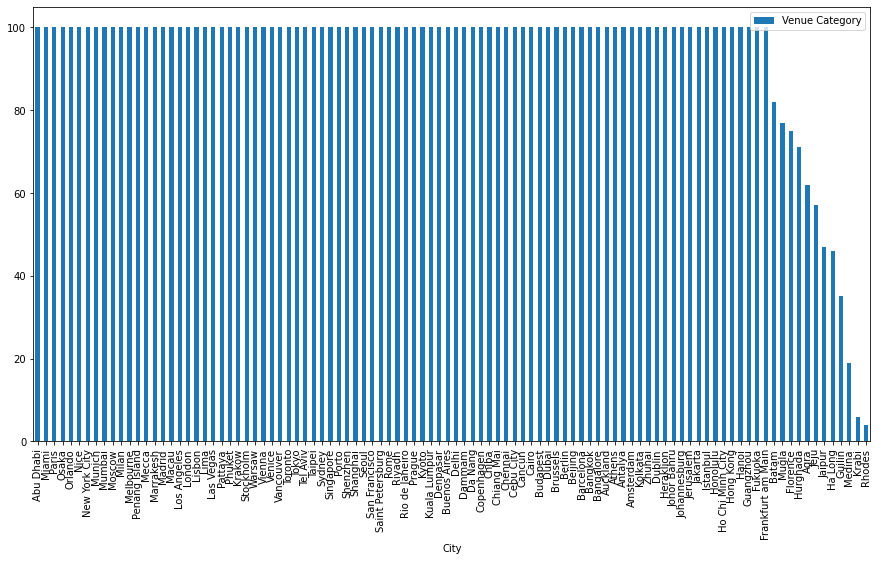

In [4]:
df_venue = pd.DataFrame(count.loc[:, 'Venue Category'])
df_venue.head()
df_venue.plot(kind ='bar', figsize=(15, 8))

As for each city less than 10 venues were returned, we will drop those cities to prevent them from spoiling the clustering

### Dropping the unwanted cities

In [5]:
top_category = world_top_venues.groupby("City").count().sort_values('Venue Category', ascending = False)
#getting the cities with less than 10 venue category
flop_country = top_category[top_category['Venue Category'] <10 ]

flop_country.reset_index(inplace = True)

flop_country_name = list(flop_country['City'])

world_top_venues.set_index('City', inplace = True)

world_top_venues_subset = world_top_venues.drop(flop_country_name)

### One Hot Encoding

In this part we will use One Hot enconding and find the venue Category that might spoil the clustering

In [6]:
#One Hot Encoding of the world_top_venues dataframe for clustering purpose
world_onehot = pd.get_dummies(world_top_venues_subset[['Venue Category']], prefix="", prefix_sep="")
pd.set_option('display.max_columns', None)
world_onehot.head()

,Abruzzo Restaurant,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,Awadhi Restaurant,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bunsik Restaurant,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Administrative Building,College Library,College Residence Hall,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Confucian Temple,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cretan Restaurant,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dive Spot,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Erotic Museum,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fish Taverna,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Indie Theater,Indonesian Meatball Place,Indonesian Restaurant,Indoor Play Area,Irani Cafe,Iraqi Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Kaiseki Restaurant,Karaoke Bar,Karaoke Box,Karnataka Restaurant,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kuruyemişçi,Kushikatsu Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lombard Restaurant,Lounge,Macanese Restaurant,Magirio,Malay Restaurant,Manadonese Restaurant,Manti Place,M

In [7]:
onehot_sum = pd.DataFrame(world_onehot.sum(axis = 0))
onehot_sum.reset_index(inplace = True)
onehot_sum.rename(columns = {0: 'Count', 'index': 'Venue Category'}, inplace = True)
onehot_sum.sort_values('Count', ascending = False, inplace = True)
onehot_sum.head(15)

,Venue Category,Count
222,Hotel,671
100,Coffee Shop,535
73,Café,408
337,Park,403
28,Bakery,240
228,Ice Cream Shop,202
355,Plaza,187
241,Italian Restaurant,173
374,Restaurant,162
213,Historic Site,133


Dropping Hotel, Café and Coffee Shop as they are very common in any big city in the world

In [8]:
world_onehot.drop(['Hotel', 'Café', 'Coffee Shop'], axis = 1, inplace = True)
world_onehot.reset_index(inplace = True)

NOW LET'S GET THE 10 MOST COMMON VENUES FOR EACH CITY

In [9]:
world_onehot.drop('Neighborhood', axis = 1, inplace = True)

#grouping for clustering
world_grouped = world_onehot.groupby('City').mean().reset_index()


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = world_grouped['City']

for ind in np.arange(world_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(world_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abu Dhabi,Middle Eastern Restaurant,Beach,Restaurant,Chinese Restaurant,Shopping Mall,Park,Steakhouse,Japanese Restaurant,Pizza Place,Resort
1,Agra,Indian Restaurant,Historic Site,Fast Food Restaurant,Resort,Multicuisine Indian Restaurant,Market,Pizza Place,Bed & Breakfast,Airport,Bistro
2,Amsterdam,Bar,Bakery,Bookstore,French Restaurant,Plaza,Park,Cocktail Bar,Restaurant,Ice Cream Shop,Wine Bar
3,Antalya,Seafood Restaurant,Restaurant,Gym,Park,Gym / Fitness Center,Scenic Lookout,Motorcycle Shop,Museum,Beach,Trail
4,Athens,Historic Site,Dessert Shop,Cocktail Bar,Souvlaki Shop,Falafel Restaurant,Meze Restaurant,History Museum,Theater,Boutique,Gourmet Shop


### END OF DATA WRANGLING SECTION

### CLUSTERING

In [10]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

world_grouped_clustering = world_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(world_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([3, 0, 1, 3, 3, 1, 3, 4, 1, 4])

Let's assign to each city its cluster label and merge that dataframe with the one containing the locations ("df"). Our final goal is to place the cities, each with a color identifying its cluster group.

In [20]:
#Assigning cluster and neighborhood to each Venue
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
world_merged = df
world_merged = world_merged.merge(city_venues_sorted.set_index('City'), on='City')
world_merged.reset_index(inplace = True)
world_merged.head()

,City,CityLatitude,CityLongitude,Country,Arrivals 2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,22.279328,114.162813,Hong Kong,"29,262,700",3,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Steakhouse,Gym / Fitness Center,Bar,Cocktail Bar,Chinese Restaurant,Scenic Lookout,Park
1,Bangkok,13.754253,100.493087,Thailand,"24,177,500",4,Thai Restaurant,Dessert Shop,Palace,Shopping Mall,Noodle House,Park,Bookstore,Bar,Asian Restaurant,Hotel Bar
2,London,51.507322,-0.127647,United Kingdom,"19,233,000",1,Park,Garden,Grocery Store,Plaza,Theater,Cocktail Bar,Art Museum,Hotel Bar,Cheese Shop,Wine Bar
3,Macau,22.175761,113.551414,Macau,"18,931,400",3,Portuguese Restaurant,Resort,Lounge,Chinese Restaurant,Cantonese Restaurant,Steakhouse,Historic Site,Italian Restaurant,Restaurant,Scenic Lookout
4,Singapore,1.357107,103.819499,Singapore,"18,551,200",3,Park,Shopping Mall,Chinese Restaurant,Cocktail Bar,Japanese Restaurant,Bakery,Indian Restaurant,Ice Cream Shop,Supermarket,Exhibit


### VISUALIZING THE CLUSTERS

In [21]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map([0,0], zoom_start=2)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(world_merged['CityLatitude'], world_merged['CityLongitude'], world_merged['City'], world_merged['Cluster Labels']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

However nothing guarantees that the clusters are homogeneous. That's why we will try to find if there isn't any outliers among the clusters

### ANALYZING EACH CLUSTER

In [23]:
#removing commas from numbers as we will convert them into floats
world_merged['Arrivals 2018'] = world_merged['Arrivals 2018'].replace(',','', regex = True)
#isolating clusters
cluster_1 = world_merged[world_merged['Cluster Labels'] == 1]
cluster_2 = world_merged[world_merged['Cluster Labels'] == 2]
cluster_3 = world_merged[world_merged['Cluster Labels'] == 3]
cluster_4 = world_merged[world_merged['Cluster Labels'] == 4]
cluster_5 = world_merged[world_merged['Cluster Labels'] == 0]

In [24]:
cluster_1.head()

,City,CityLatitude,CityLongitude,Country,Arrivals 2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,London,51.507322,-0.127647,United Kingdom,19233000,1,Park,Garden,Grocery Store,Plaza,Theater,Cocktail Bar,Art Museum,Hotel Bar,Cheese Shop,Wine Bar
5,Paris,48.856697,2.351462,France,17560200,1,Wine Bar,Plaza,Italian Restaurant,French Restaurant,Bookstore,Art Museum,Bakery,Garden,Creperie,Bistro
7,New York City,40.712728,-74.006015,United States,13600000,1,Park,Ice Cream Shop,Bakery,Theater,Movie Theater,Scenic Lookout,Pier,Gourmet Shop,Bookstore,Yoga Studio
15,Rome,41.893320,12.482932,Italy,10065400,1,Plaza,Ice Cream Shop,Pizza Place,Italian Restaurant,Park,Historic Site,Sandwich Place,Church,Bakery,Scenic Lookout
21,Prague,50.087465,14.421254,Czech Republic,8948600,1,Park,Ice Cream Shop,Scenic Lookout,Garden,Cocktail Bar,Burger Joint,Noodle House,Plaza,Bar,Bakery


In [25]:
cluster_2.head()

,City,CityLatitude,CityLongitude,Country,Arrivals 2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,Fukuoka,33.625124,130.618002,Japan,2436900,2,Convenience Store,Ramen Restaurant,Train Station,Sushi Restaurant,Discount Store,Hot Spring,Ice Cream Shop,Noodle House,Outdoor Sculpture,Tunnel


In [26]:
cluster_3.head()

,City,CityLatitude,CityLongitude,Country,Arrivals 2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,22.279328,114.162813,Hong Kong,29262700,3,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Steakhouse,Gym / Fitness Center,Bar,Cocktail Bar,Chinese Restaurant,Scenic Lookout,Park
3,Macau,22.175761,113.551414,Macau,18931400,3,Portuguese Restaurant,Resort,Lounge,Chinese Restaurant,Cantonese Restaurant,Steakhouse,Historic Site,Italian Restaurant,Restaurant,Scenic Lookout
4,Singapore,1.357107,103.819499,Singapore,18551200,3,Park,Shopping Mall,Chinese Restaurant,Cocktail Bar,Japanese Restaurant,Bakery,Indian Restaurant,Ice Cream Shop,Supermarket,Exhibit
6,Dubai,25.065964,55.171340,United Arab Emirates,15920700,3,Shopping Mall,Lounge,Restaurant,Resort,Supermarket,Beach,Food Truck,Multiplex,Golf Course,Gym
8,Kuala Lumpur,3.151696,101.694237,Malaysia,13434300,3,Shopping Mall,Hotel Bar,Spa,Malay Restaurant,Grocery Store,Cocktail Bar,Bar,Ice Cream Shop,Resort,Indian Restaurant


In [27]:
cluster_4.head()

,City,CityLatitude,CityLongitude,Country,Arrivals 2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bangkok,13.754253,100.493087,Thailand,24177500,4,Thai Restaurant,Dessert Shop,Palace,Shopping Mall,Noodle House,Park,Bookstore,Bar,Asian Restaurant,Hotel Bar
14,Phuket,7.936602,98.352929,Thailand,10550700,4,Thai Restaurant,Resort,Ice Cream Shop,Dim Sum Restaurant,Department Store,Restaurant,Shrine,Bar,Massage Studio,Golf Course
17,Pattaya,12.931941,100.900953,Thailand,9606400,4,Thai Restaurant,Resort,Restaurant,Spa,Noodle House,Nightclub,Hotel Bar,Massage Studio,Seafood Restaurant,Clothing Store
30,Ho Chi Minh City,10.775844,106.701755,Vietnam,7200000,4,Vietnamese Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Thai Restaurant,Spa,Whisky Bar,Bar,Sushi Restaurant,German Restaurant
31,Denpasar,-8.652497,115.219118,Indonesia,7185600,4,Indonesian Restaurant,Bakery,Restaurant,Resort,Chinese Restaurant,Ice Cream Shop,Convenience Store,Asian Restaurant,Pizza Place,Kids Store


In [28]:
cluster_5.head()

,City,CityLatitude,CityLongitude,Country,Arrivals 2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Delhi,28.651718,77.221939,India,12645300,0,Indian Restaurant,Bar,Lounge,South Indian Restaurant,Park,Fast Food Restaurant,Restaurant,Tibetan Restaurant,Italian Restaurant,Art Gallery
25,Agra,27.175255,78.009816,India,8138200,0,Indian Restaurant,Historic Site,Fast Food Restaurant,Resort,Multicuisine Indian Restaurant,Market,Pizza Place,Bed & Breakfast,Airport,Bistro
35,Chennai,13.080172,80.283833,India,6422800,0,Indian Restaurant,Italian Restaurant,Fast Food Restaurant,Multiplex,Juice Bar,Ice Cream Shop,Sandwich Place,Beach,Snack Place,Park


### FINDIND THE OUTLIERS IN CLUSTERS

In every cluster there might be oultiers to which the rules does not apply to. Let's try to identify them

### Joining each cluster with population that visits it

In [29]:
df_cluster_1 = pd.DataFrame.copy(cluster_1.iloc[:,0:5])
df_cluster_2 = pd.DataFrame.copy(cluster_2.iloc[:,0:5])
df_cluster_3 = pd.DataFrame.copy(cluster_3.iloc[:,0:5])
df_cluster_4 = pd.DataFrame.copy(cluster_4.iloc[:,0:5])
df_cluster_5 = pd.DataFrame.copy(cluster_5.iloc[:,0:5])

In [30]:
df_cluster_1['Arrivals 2018'] = df_cluster_1['Arrivals 2018'].astype('float')
df_cluster_2['Arrivals 2018'] = df_cluster_2['Arrivals 2018'].astype('float')
df_cluster_3['Arrivals 2018'] = df_cluster_3['Arrivals 2018'].astype('float')
df_cluster_4['Arrivals 2018'] = df_cluster_4['Arrivals 2018'].astype('float')
df_cluster_5['Arrivals 2018'] = df_cluster_5['Arrivals 2018'].astype('float')

In [32]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Cluster 1')

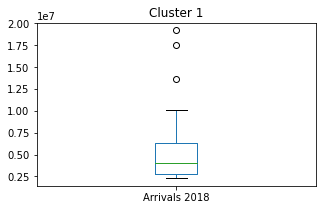

In [34]:
df_cluster_1['Arrivals 2018'].plot(kind = 'box', figsize = (5, 3))
plt.title("Cluster 1")

Text(0.5, 1.0, 'Cluster 2')

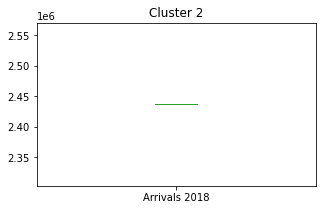

In [35]:
df_cluster_2['Arrivals 2018'].plot(kind = 'box', figsize = (5, 3))
plt.title("Cluster 2")

Text(0.5, 1.0, 'Cluster 3')

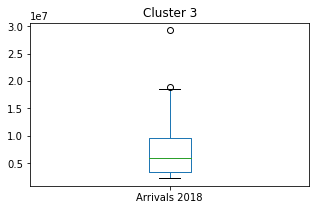

In [36]:
df_cluster_3['Arrivals 2018'].plot(kind = 'box', figsize = (5, 3))
plt.title("Cluster 3")

Text(0.5, 1.0, 'Cluster 4')

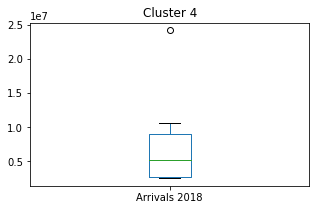

In [37]:
df_cluster_4['Arrivals 2018'].plot(kind = 'box', figsize = (5, 3))
plt.title("Cluster 4")

Text(0.5, 1.0, 'Cluster 5')

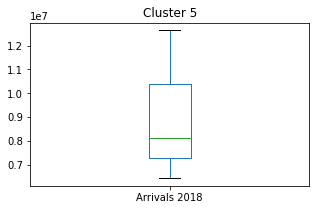

In [38]:
df_cluster_5['Arrivals 2018'].plot(kind = 'box', figsize = (5, 3))
plt.title("Cluster 5")

So cluster 